# IMPORTA BIBLIOTECAS

In [1]:
# MANIPULAÇÃO DE DADOS
import pandas as pd
import numpy as np

# VISUALIZAÇÃO DE DADOS
import matplotlib.pyplot as plt

# TRANSFORMAÇÕES
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from imblearn import over_sampling


# PREPARAÇÃO TREINO E AVALIAÇÃO
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# MODELOS UTILIZADOS
from mixed_naive_bayes import MixedNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# CONFIGURAÇÕES DE EXIBIÇÃO
import warnings

warnings.filterwarnings("ignore")

# pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

# IMPORTAÇÃO DE DADOS

In [2]:
weather_aus = pd.read_csv("../DATA/weatherAUS.csv").dropna()

print(
    f"O dataset possui {weather_aus.shape[0]:,} instâncias (linhas) e {weather_aus.shape[1]:,} características (colunas)."
)

print(f"As características (colunas) do dataset são: {weather_aus.columns.to_list()}")

O dataset possui 56,420 instâncias (linhas) e 23 características (colunas).
As características (colunas) do dataset são: ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']


# FUNÇÕES PARA PRÉ-PROCESSAMENTO


In [3]:
def split_data(df, target_column):
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Dividir a base em treino e teste, mantendo a proporção das classes
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    df_train = pd.concat([X_train, y_train], axis=1)
    df_test = pd.concat([X_test, y_test], axis=1)

    return df_train, df_test

In [4]:
def adjust_data_types(df):
    df.RainTomorrow = df.RainTomorrow.map({"Yes": 1, "No": 0})

    return df


In [5]:
def create_auxiliar_columns(df):
    # COLUNAS SELECIONADAS COM BASE NAS AVALIAÇÕES ANTERIORES
    df = df[
        [
            "MinTemp",
            "MaxTemp",
            "Rainfall",
            "Evaporation",
            "Sunshine",
            "WindGustSpeed",
            "WindSpeed9am",
            "WindSpeed3pm",
            "Humidity9am",
            "Humidity3pm",
            "Pressure3pm",
            "Cloud9am",
            "Cloud3pm",
            "RainTomorrow",
            "WindGustDir",
            "WindDir3pm",
        ]
    ]

    df["RangeTemp"] = df["MaxTemp"] - df["MinTemp"]

    # SEPARA AS VARIÁVEIS CATEGÓRICAS E NUMÉRICAS
    # CATEGORIZA AS VARIÁVEIS NECESSÁRIAS
    categorical_columns = pd.get_dummies(
        df.select_dtypes(include=["object", "datetime64"]),
        columns=["WindGustDir", "WindDir3pm"],
        drop_first=True,
        prefix=["WindGustDir", "WindDir3pm"],
        dtype=int,
    )

    numerical_columns = df.select_dtypes(include=["int64", "float64"])

    df = pd.concat([numerical_columns, categorical_columns], axis=1)

    return df


In [6]:
def instance_transformations(n_components=5):
    discretizer = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="kmeans")
    smote = over_sampling.SMOTE()

    scaler = StandardScaler()
    pca = PCA(n_components=n_components)

    return discretizer, scaler, pca, smote

In [7]:
def adjust_train_volume(df, target_column, smote):
    X = df.drop(columns=[target_column])
    y = df[target_column]

    X_res, y_res = smote.fit_resample(X, y)
    df_smote = pd.concat([X_res, y_res], axis=1)

    return df_smote

In [8]:
def fit_transformmations(df, cols, discretizer, scaler, pca, discrete_col="Rainfall"):
    discretizer.fit(df[discrete_col].values.reshape(-1, 1))

    scaler.fit(df[cols])
    pca.fit(df[cols])

    return discretizer, scaler, pca


In [9]:
def transform_data(df, cols, discretizer, scaler, pca, discrete_col="Rainfall"):
    df[discrete_col + "_Discretized"] = discretizer.transform(
        df[discrete_col].values.reshape(-1, 1)
    )
    df[cols] = scaler.transform(df[cols])
    df = df.reset_index(drop=True)

    pca_result = pca.transform(df[cols])

    df_pca = pd.DataFrame(
        data=pca_result,
        columns=[f"PC{comp}" for comp in range(1, pca.n_components_ + 1)],
    )
    df_pca = df_pca.reset_index(drop=True)
    df_pca["RainTomorrow"] = df["RainTomorrow"]

    return df, df_pca

# INICIO PRÉ-PROCESSAMENTO

SEPARA EM TREINO E TESTE

In [10]:
df_train, df_test = split_data(weather_aus, "RainTomorrow")

## PRÉ-PROCESSAMENTO NA BASE DE TREINO

AJUSTA TIPOS DE DADOS NO TREINO

In [11]:
df_train = adjust_data_types(df_train)

CRIA VARIÁVEIS AUXILIARES

In [12]:
df_train = create_auxiliar_columns(df_train)

CRIA AS INSTÂNCIAS DAS TRANSFORMAÇÕES

In [13]:
discretizer, scaler, pca, smote = instance_transformations()

AJUSTA O VOLUME DE TREINO

In [14]:
(
    df_train.RainTomorrow.value_counts(dropna=False),
    df_train.RainTomorrow.value_counts(normalize=True, dropna=False),
)

(RainTomorrow
 0    35194
 1     9942
 Name: count, dtype: int64,
 RainTomorrow
 0    0.779732
 1    0.220268
 Name: proportion, dtype: float64)

In [15]:
df_train = adjust_train_volume(df_train, "RainTomorrow", smote)

In [16]:
(
    df_train.RainTomorrow.value_counts(dropna=False),
    df_train.RainTomorrow.value_counts(normalize=True, dropna=False),
)

(RainTomorrow
 1    35194
 0    35194
 Name: count, dtype: int64,
 RainTomorrow
 1    0.5
 0    0.5
 Name: proportion, dtype: float64)

TREINA AS TRANSFORMAÇÕES COM A BASE DE TREINO

In [17]:
continuous_columns = [
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "Evaporation",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed9am",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "RangeTemp",
]

categorical_columns = [
    "WindGustDir_ENE",
    "WindGustDir_ESE",
    "WindGustDir_N",
    "WindGustDir_NE",
    "WindGustDir_NNE",
    "WindGustDir_NNW",
    "WindGustDir_NW",
    "WindGustDir_S",
    "WindGustDir_SE",
    "WindGustDir_SSE",
    "WindGustDir_SSW",
    "WindGustDir_SW",
    "WindGustDir_W",
    "WindGustDir_WNW",
    "WindGustDir_WSW",
    "WindDir3pm_ENE",
    "WindDir3pm_ESE",
    "WindDir3pm_N",
    "WindDir3pm_NE",
    "WindDir3pm_NNE",
    "WindDir3pm_NNW",
    "WindDir3pm_NW",
    "WindDir3pm_S",
    "WindDir3pm_SE",
    "WindDir3pm_SSE",
    "WindDir3pm_SSW",
    "WindDir3pm_SW",
    "WindDir3pm_W",
    "WindDir3pm_WNW",
    "WindDir3pm_WSW",
    "Rainfall_Discretized",
]

discretizer, scaler, pca = fit_transformmations(
    df_train, continuous_columns, discretizer, scaler, pca
)

APLICA AS TRANSFORMAÇÕES NA BASE DE TREINO

In [18]:
df_train, df_train_pca = transform_data(
    df_train, continuous_columns, discretizer, scaler, pca
)

## APLICAÇÕES SOBRE BASE DE TESTE

AJUSTA OS TIPOS DE DADOS

In [19]:
df_test = adjust_data_types(df_test)

CRIA AS COLUNAS AUXILIARES

In [20]:
df_test = create_auxiliar_columns(df_test)

APLICA AS TRANSFORMAÇÕES JÁ TREINADAS

In [21]:
df_test, df_test_pca = transform_data(
    df_test, continuous_columns, discretizer, scaler, pca
)

In [22]:
(
    df_test.RainTomorrow.value_counts(dropna=False),
    df_test.RainTomorrow.value_counts(normalize=True, dropna=False),
)

(RainTomorrow
 0    8799
 1    2485
 Name: count, dtype: int64,
 RainTomorrow
 0    0.779777
 1    0.220223
 Name: proportion, dtype: float64)

# PROCESSO DE MODELAGEM

FUNÇÃO DE APLICAÇÃO DE MODELOS

In [23]:
def run_cross_validation(
    train_data, train_target, test_data, test_target, model, param_grid, k_folds=10
):
    skf = StratifiedKFold(n_splits=k_folds, random_state=42)
    scores_validation = {"f1": [], "accuracy": [], "precision": [], "recall": []}
    scores_test = {"f1": [], "accuracy": [], "precision": [], "recall": []}
    best_params = None 
    best_model = None
    best_f1 = 0

    for train_index, valid_index in skf.split(train_data, train_target):
        # Use .iloc to select rows based on indices
        X_train_fold, X_valid_fold = (
            train_data.iloc[train_index],
            train_data.iloc[valid_index],
        )
        y_train_fold, y_valid_fold = (
            train_target.iloc[train_index],
            train_target.iloc[valid_index],
        )

        # Etapa 2: Treinamento e ajuste de hiperparâmetros com validação cruzada interna
        grid_search = GridSearchCV(
            model, param_grid, scoring="f1", cv=StratifiedKFold(n_splits=3)
        )
        grid_search.fit(X_train_fold, y_train_fold)
        model = grid_search.best_estimator_
        f1 = grid_search.best_score_

        if f1 > best_f1:
            best_model = model
            best_params = grid_search.best_params_
            best_f1 = f1

        # Avaliação nos dados de validação
        y_valid_pred = model.predict(X_valid_fold)

        # Cálculo das métricas no fold
        scores_validation["f1"].append(
            f1_score(y_valid_fold, y_valid_pred, average="macro")
        )
        scores_validation["accuracy"].append(accuracy_score(y_valid_fold, y_valid_pred))
        scores_validation["precision"].append(
            precision_score(y_valid_fold, y_valid_pred, average="macro")
        )
        scores_validation["recall"].append(
            recall_score(y_valid_fold, y_valid_pred, average="macro")
        )

        # Avaliar na base de teste com o melhor modelo
        y_test_pred = model.predict(test_data)
        f1_test = f1_score(test_target, y_test_pred, average="macro")
        accuracy_test = accuracy_score(test_target, y_test_pred)
        precision_test = precision_score(test_target, y_test_pred, average="macro")
        recall_test = recall_score(test_target, y_test_pred, average="macro")

        # Armazenar as métricas na base de teste
        scores_test["f1"].append(f1_test)
        scores_test["accuracy"].append(accuracy_test)
        scores_test["precision"].append(precision_test)
        scores_test["recall"].append(recall_test)

    # Calcula as médias das métricas nos folds de validação
    avg_scores_validation = {
        metric: np.mean(values) for metric, values in scores_validation.items()
    }
    test_scores = {metric: np.mean(values) for metric, values in scores_test.items()}

    # Criar log dos resultados
    log = pd.DataFrame(scores_validation)
    log["dataset"] = "Validação Cruzada"

    test_log = pd.DataFrame(scores_test)
    test_log["dataset"] = "Teste"

    # Concatenar os logs da validação cruzada e do teste
    full_log = pd.concat([log, test_log])

    return avg_scores_validation, test_scores, best_params, full_log

In [26]:
def run_cross_mix(
    train_data,
    train_target,
    test_data,
    test_target,
    alphas,
    k_folds=10,
    categorical_features=None,
):
    skf = StratifiedKFold(n_splits=k_folds, random_state=42)
    scores_validation = {"f1": [], "accuracy": [], "precision": [], "recall": []}
    scores_test = {"f1": [], "accuracy": [], "precision": [], "recall": []}
    best_model = None
    best_alpha = None
    best_f1 = 0

    # Validação cruzada estratificada
    for train_index, valid_index in skf.split(train_data, train_target):
        X_train_fold, X_valid_fold = (
            train_data.iloc[train_index],
            train_data.iloc[valid_index],
        )
        y_train_fold, y_valid_fold = (
            train_target.iloc[train_index],
            train_target.iloc[valid_index],
        )

        # Iterar pelos valores de alpha
        for alpha in alphas:
            # Treina o modelo com o valor de alpha atual
            model = MixedNB(categorical_features=categorical_features, alpha=alpha)
            model.fit(X_train_fold, y_train_fold)

            # Avaliação nos dados de validação
            y_valid_pred = model.predict(X_valid_fold)
            f1 = f1_score(y_valid_fold, y_valid_pred, average="macro")
            accuracy = accuracy_score(y_valid_fold, y_valid_pred)
            precision = precision_score(y_valid_fold, y_valid_pred, average="macro")
            recall = recall_score(y_valid_fold, y_valid_pred, average="macro")

            # Seleciona o melhor modelo baseado na métrica F1-score
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                best_alpha = alpha

        # Armazenar as métricas para o fold atual
        scores_validation["f1"].append(f1)
        scores_validation["accuracy"].append(accuracy)
        scores_validation["precision"].append(precision)
        scores_validation["recall"].append(recall)

        # Avaliar na base de teste com o melhor modelo
        y_test_pred = model.predict(test_data)
        f1_test = f1_score(test_target, y_test_pred, average="macro")
        accuracy_test = accuracy_score(test_target, y_test_pred)
        precision_test = precision_score(test_target, y_test_pred, average="macro")
        recall_test = recall_score(test_target, y_test_pred, average="macro")

        # Armazenar as métricas na base de teste
        scores_test["f1"].append(f1_test)
        scores_test["accuracy"].append(accuracy_test)
        scores_test["precision"].append(precision_test)
        scores_test["recall"].append(recall_test)

    # Calcular as médias das métricas de validação cruzada
    avg_scores_validation = {
        metric: np.mean(values) for metric, values in scores_validation.items()
    }
    test_scores = {metric: np.mean(values) for metric, values in scores_test.items()}

    # Criar log dos resultados
    log = pd.DataFrame(scores_validation)
    log["dataset"] = "Validação Cruzada"

    test_log = pd.DataFrame(scores_test)
    test_log["dataset"] = "Teste"

    # Concatenar os logs da validação cruzada e do teste
    full_log = pd.concat([log, test_log])

    return avg_scores_validation, best_alpha, test_scores, full_log


## BAYES

### TODAS AS CARACTERÍSTICAS

In [27]:
# Parâmetros do modelo
alphas = [0.0, 0.01, 0.1, 0.5, 1.0]

# Executar para diferentes modelos e conjuntos de dados
results_validation_v2, best_params_v2, results_test_v2, results_list_full_v2 = (
    run_cross_mix(
        df_train.drop(columns=["RainTomorrow"]),
        df_train["RainTomorrow"],
        df_test.drop(columns=["RainTomorrow"]),
        df_test["RainTomorrow"],
        alphas,
        k_folds=10,
        categorical_features=[
            df_train.drop(columns="RainTomorrow").columns.get_loc(col)
            for col in categorical_columns
        ],
    )
)

print("Resultados na validação cruzada:", results_validation_v2)
print("Resultados na base de teste:", results_test_v2)
print("Melhores parâmetros escolhidos:", best_params_v2)

Resultados na validação cruzada: {'f1': np.float64(0.7876838326868907), 'accuracy': np.float64(0.7878192242861101), 'precision': np.float64(0.7884438493339435), 'recall': np.float64(0.7878212552313416)}
Resultados na base de teste: {'f1': np.float64(0.7241853383894145), 'accuracy': np.float64(0.7823909961006736), 'precision': np.float64(0.7088892579980844), 'recall': np.float64(0.7648136231870138)}
Melhores parâmetros escolhidos: 0.0


In [28]:
results_list_full_v2

,f1,accuracy,precision,recall,dataset
0,0.760681,0.761188,0.763434,0.761194,Validação Cruzada
1,0.757357,0.757920,0.760350,0.757927,Validação Cruzada
2,0.772723,0.772837,0.773395,0.772840,Validação Cruzada
3,0.801810,0.801818,0.801868,0.801818,Validação Cruzada
4,0.799400,0.799403,0.799425,0.799404,Validação Cruzada
5,0.795706,0.795710,0.795731,0.795710,Validação Cruzada
6,0.794700,0.794715,0.794803,0.794716,Validação Cruzada
7,0.799357,0.799403,0.799685,0.799406,Validação Cruzada
8,0.792799,0.792839,0.793066,0.792839,Validação Cruzada
9,0.802306,0.802359,0.802682,0.802359,Validação Cruzada


### PCA

In [41]:
# Parâmetros do modelo
param_grid_categorical = {"var_smoothing": [0.0, 0.01, 0.1, 0.5, 1.0]}

# Executar a função e obter os melhores parâmetros
results_validation, results_test, best_params, results_list_pca = run_cross_validation(
    df_train_pca.drop(columns=["RainTomorrow"]),
    df_train_pca["RainTomorrow"],
    df_test_pca.drop(columns=["RainTomorrow"]),
    df_test_pca["RainTomorrow"],
    GaussianNB(),
    param_grid_categorical,
    k_folds=10,
)

print("Resultados na validação cruzada:", results_validation)
print("Resultados na base de teste:", results_test)
print("Melhores parâmetros escolhidos:", best_params)

Resultados na validação cruzada: {'f1': np.float64(0.7581842401023273), 'accuracy': np.float64(0.7593764691268042), 'precision': np.float64(0.7645942461548055), 'recall': np.float64(0.7593765944289441)}
Resultados na base de teste: {'f1': np.float64(0.7330070069281078), 'accuracy': np.float64(0.7979085430698334), 'precision': np.float64(0.7183002417298281), 'recall': np.float64(0.7599788388245143)}
Melhores parâmetros escolhidos: {'var_smoothing': 1.0}


In [ ]:
results_list_pca

,f1,accuracy,precision,recall,dataset
0,0.762892,0.764171,0.770019,0.764181,Validação Cruzada
1,0.759282,0.760193,0.764210,0.760202,Validação Cruzada
2,0.768620,0.769570,0.774089,0.769579,Validação Cruzada
3,0.763654,0.764739,0.769714,0.764749,Validação Cruzada
4,0.763007,0.763887,0.767849,0.763878,Validação Cruzada
5,0.755718,0.756784,0.761326,0.756774,Validação Cruzada
6,0.763989,0.764739,0.768134,0.764731,Validação Cruzada
7,0.756732,0.757494,0.760745,0.757486,Validação Cruzada
8,0.754258,0.755044,0.758349,0.755044,Validação Cruzada
9,0.761811,0.762717,0.766774,0.762717,Validação Cruzada


### CORRELAÇÃO

In [29]:
# Parâmetros do modelo
alphas = [0.0, 0.01, 0.1, 0.5, 1.0]

filtro_correlacao = [
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "Evaporation",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "RangeTemp",
    "Rainfall_Discretized",
]

# Executar para diferentes modelos e conjuntos de dados
results_validation_v2, best_params_v2, results_test_v2, results_list_corr_v2 = (
    run_cross_mix(
        df_train[filtro_correlacao],
        df_train["RainTomorrow"],
        df_test[filtro_correlacao],
        df_test["RainTomorrow"],
        alphas,
        k_folds=10,
        categorical_features=[13],
    )
)

print("Resultados na validação cruzada:", results_validation_v2)
print("Resultados na base de teste:", results_test_v2)
print("Melhores parâmetros escolhidos:", best_params_v2)

Resultados na validação cruzada: {'f1': np.float64(0.7654480306433445), 'accuracy': np.float64(0.7654572072996786), 'precision': np.float64(0.7654988278764114), 'recall': np.float64(0.765457112686972)}
Resultados na base de teste: {'f1': np.float64(0.71459690236761), 'accuracy': np.float64(0.7671393123006027), 'precision': np.float64(0.7015738281479271), 'recall': np.float64(0.7672921858918026)}
Melhores parâmetros escolhidos: 0.0


In [30]:
results_list_corr_v2

,f1,accuracy,precision,recall,dataset
0,0.764170,0.764171,0.764174,0.764171,Validação Cruzada
1,0.761471,0.761472,0.761473,0.761472,Validação Cruzada
2,0.764722,0.764739,0.764816,0.764738,Validação Cruzada
3,0.771981,0.771985,0.772001,0.771984,Validação Cruzada
4,0.766298,0.766302,0.766318,0.766301,Validação Cruzada
5,0.766870,0.766870,0.766873,0.766870,Validação Cruzada
6,0.760761,0.760761,0.760763,0.760762,Validação Cruzada
7,0.765438,0.765450,0.765505,0.765451,Validação Cruzada
8,0.764256,0.764280,0.764387,0.764280,Validação Cruzada
9,0.768513,0.768542,0.768678,0.768542,Validação Cruzada


### RANDOM FOREST - FEATURE IMPORTANCE

In [50]:
# Parâmetros do modelo
param_grid_categorical = {"var_smoothing": [0.0, 0.01, 0.1, 0.5, 1.0]}

caracteristicas_filtro = [
    "Humidity3pm",
    "Cloud3pm",
    "Sunshine",
    "Rainfall",
    "Pressure3pm",
    "Cloud9am",
    "WindGustSpeed",
    "RangeTemp",
    "Humidity9am",
    "MinTemp",
]

# Executar a função e obter os melhores parâmetros
results_validation, results_test, best_params, results_list_rd = run_cross_validation(
    df_train[caracteristicas_filtro],
    df_train["RainTomorrow"],
    df_test[caracteristicas_filtro],
    df_test["RainTomorrow"],
    GaussianNB(),
    param_grid_categorical,
    k_folds=10,
)

print("Resultados na validação cruzada:", results_validation)
print("Resultados na base de teste:", results_test)
print("Melhores parâmetros escolhidos:", best_params)

Resultados na validação cruzada: {'f1': np.float64(0.7684789976918471), 'accuracy': np.float64(0.768568456802661), 'precision': np.float64(0.7689824362484677), 'recall': np.float64(0.7685685216939213)}
Resultados na base de teste: {'f1': np.float64(0.7115082989881153), 'accuracy': np.float64(0.7610333215171925), 'precision': np.float64(0.7002464782345884), 'recall': np.float64(0.7704084010827095)}
Melhores parâmetros escolhidos: {'var_smoothing': 1.0}


In [ ]:
results_list_rd

,f1,accuracy,precision,recall,dataset
0,0.769915,0.769996,0.770371,0.769993,Validação Cruzada
1,0.762578,0.762608,0.762741,0.762607,Validação Cruzada
2,0.766624,0.766728,0.767201,0.766725,Validação Cruzada
3,0.769252,0.769285,0.769439,0.769284,Validação Cruzada
4,0.781443,0.781503,0.781820,0.781505,Validação Cruzada
5,0.774494,0.774542,0.774777,0.774544,Validação Cruzada
6,0.770561,0.770706,0.771400,0.770710,Validação Cruzada
7,0.766279,0.766444,0.767206,0.766448,Validação Cruzada
8,0.768501,0.768684,0.769538,0.768684,Validação Cruzada
9,0.770827,0.770958,0.771577,0.770958,Validação Cruzada


## RANDOM FOREST - CLASSIFIER

### TODAS AS CARACTERÍSTICAS

In [25]:
param_grid_categorical = {
    "n_estimators": [500, 700, 1000],
    "max_features": ["sqrt", "log2", 10, None],
}

# Executar a função e obter os melhores parâmetros
results_validation, results_test, best_params, results_list_full = run_cross_validation(
    df_train.drop(columns=["RainTomorrow"]),
    df_train["RainTomorrow"],
    df_test.drop(columns=["RainTomorrow"]),
    df_test["RainTomorrow"],
    RandomForestClassifier(n_jobs=-1, random_state=42, max_depth=None),
    param_grid_categorical,
    k_folds=10,
)

print("Resultados na validação cruzada:", results_validation)
print("Resultados na base de teste:", results_test)
print("Melhores parâmetros escolhidos:", best_params)

Resultados na validação cruzada: {'f1': np.float64(0.907596246364782), 'accuracy': np.float64(0.9084371383387024), 'precision': np.float64(0.9158489692556149), 'recall': np.float64(0.9084438252409001)}
Resultados na base de teste: {'f1': np.float64(0.7771179189597431), 'accuracy': np.float64(0.8514976958525347), 'precision': np.float64(0.7872567574489114), 'recall': np.float64(0.769579081489734)}
Melhores parâmetros escolhidos: {'max_features': 'sqrt', 'n_estimators': 1000}


In [31]:
results_list_full

,f1,accuracy,precision,recall,dataset
0,0.807889,0.811337,0.835464,0.811356,Validação Cruzada
1,0.802518,0.805654,0.826429,0.805672,Validação Cruzada
2,0.841856,0.843160,0.854889,0.843172,Validação Cruzada
3,0.946522,0.946583,0.948639,0.946579,Validação Cruzada
4,0.949633,0.949709,0.952447,0.949714,Validação Cruzada
5,0.947225,0.947294,0.949650,0.947299,Validação Cruzada
6,0.944945,0.945021,0.947477,0.945026,Validação Cruzada
7,0.945355,0.945447,0.948487,0.945453,Validação Cruzada
8,0.945359,0.945439,0.948077,0.945439,Validação Cruzada
9,0.944660,0.944729,0.946931,0.944729,Validação Cruzada


### PCA

In [27]:
param_grid_categorical = {
    "n_estimators": [500, 700, 1000],
    "max_features": ["sqrt", "log2", None],
}

# Executar a função e obter os melhores parâmetros
results_validation, results_test, best_params, results_list_pca = run_cross_validation(
    df_train_pca.drop(columns=["RainTomorrow"]),
    df_train_pca["RainTomorrow"],
    df_test_pca.drop(columns=["RainTomorrow"]),
    df_test_pca["RainTomorrow"],
    RandomForestClassifier(n_jobs=-1, random_state=42, max_depth=None),
    param_grid_categorical,
    k_folds=10,
)

print("Resultados na validação cruzada:", results_validation)
print("Resultados na base de teste:", results_test)
print("Melhores parâmetros escolhidos:", best_params)

Resultados na validação cruzada: {'f1': np.float64(0.8449892776340124), 'accuracy': np.float64(0.8450588409696943), 'precision': np.float64(0.8456939736212039), 'recall': np.float64(0.8450595266927587)}
Resultados na base de teste: {'f1': np.float64(0.7285141444567097), 'accuracy': np.float64(0.7948333924140376), 'precision': np.float64(0.7142450042827266), 'recall': np.float64(0.7545129648215466)}
Melhores parâmetros escolhidos: {'max_features': 'sqrt', 'n_estimators': 500}


In [30]:
results_list_pca

,f1,accuracy,precision,recall,dataset
0,0.832788,0.832789,0.832795,0.832788,Validação Cruzada
1,0.838002,0.838045,0.838401,0.838043,Validação Cruzada
2,0.841702,0.841739,0.842050,0.841737,Validação Cruzada
3,0.852044,0.852110,0.852726,0.852107,Validação Cruzada
4,0.851438,0.851541,0.852535,0.851545,Validação Cruzada
5,0.849767,0.849837,0.850498,0.849840,Validação Cruzada
6,0.847750,0.847848,0.848748,0.847851,Validação Cruzada
7,0.844735,0.844864,0.846025,0.844868,Validação Cruzada
8,0.846447,0.846547,0.847456,0.846547,Validação Cruzada
9,0.845220,0.845269,0.845705,0.845269,Validação Cruzada


### CORRELAÇÃO

In [24]:
param_grid_categorical = {
    "n_estimators": [500, 700, 1000],
    "max_features": ["sqrt", "log2", 10, None],
}

filtro_correlacao = [
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "Evaporation",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "RangeTemp",
    "Rainfall_Discretized",
]

# Executar para diferentes modelos e conjuntos de dados
results_validation_v2, best_params_v2, results_test_v2, results_list_corr_v2 = (
    run_cross_validation(
        df_train[filtro_correlacao],
        df_train["RainTomorrow"],
        df_test[filtro_correlacao],
        df_test["RainTomorrow"],
        RandomForestClassifier(n_jobs=-1, random_state=42, max_depth=None),
        param_grid_categorical,
        k_folds=10,
    )
)

print("Resultados na validação cruzada:", results_validation_v2)
print("Resultados na base de teste:", results_test_v2)
print("Melhores parâmetros escolhidos:", best_params_v2)

Resultados na validação cruzada: {'f1': np.float64(0.9114930451225385), 'accuracy': np.float64(0.9118039505550228), 'precision': np.float64(0.9160946004562808), 'recall': np.float64(0.9118087403769148)}
Resultados na base de teste: {'max_features': 'sqrt', 'n_estimators': 1000}
Melhores parâmetros escolhidos: {'f1': np.float64(0.780974350923801), 'accuracy': np.float64(0.8490872031194611), 'precision': np.float64(0.7803952870329318), 'recall': np.float64(0.7819808108795974)}


In [25]:
results_list_corr_v2

,f1,accuracy,precision,recall,dataset
0,0.840344,0.841455,0.851254,0.841467,Validação Cruzada
1,0.830728,0.831652,0.839079,0.831663,Validação Cruzada
2,0.865992,0.866316,0.869909,0.866323,Validação Cruzada
3,0.939947,0.940048,0.943019,0.940042,Validação Cruzada
4,0.939657,0.939764,0.942935,0.939770,Validação Cruzada
5,0.940945,0.941043,0.943991,0.941049,Validação Cruzada
6,0.938940,0.939054,0.942371,0.939060,Validação Cruzada
7,0.938504,0.938628,0.942187,0.938634,Validação Cruzada
8,0.941229,0.941319,0.944030,0.941319,Validação Cruzada
9,0.938643,0.938761,0.942170,0.938761,Validação Cruzada


### RAIN FOREST - FEATURE IMPORTANCE

In [28]:
param_grid_categorical = {
    "n_estimators": [500, 700, 1000],
    "max_features": ["sqrt", "log2", 10, None],
}

caracteristicas_filtro = [
    "Humidity3pm",
    "Cloud3pm",
    "Sunshine",
    "Rainfall",
    "Pressure3pm",
    "Cloud9am",
    "WindGustSpeed",
    "RangeTemp",
    "Humidity9am",
    "MinTemp",
]

# Executar a função e obter os melhores parâmetros
results_validation, results_test, best_params, results_list_rd = run_cross_validation(
    df_train[caracteristicas_filtro],
    df_train["RainTomorrow"],
    df_test[caracteristicas_filtro],
    df_test["RainTomorrow"],
    RandomForestClassifier(n_jobs=-1, random_state=42, max_depth=None),
    param_grid_categorical,
    k_folds=10,
)

print("Resultados na validação cruzada:", results_validation)
print("Resultados na base de teste:", results_test)
print("Melhores parâmetros escolhidos:", best_params)

Resultados na validação cruzada: {'f1': np.float64(0.9075389438436424), 'accuracy': np.float64(0.9079965713696527), 'precision': np.float64(0.9132068271767093), 'recall': np.float64(0.9080020957658425)}
Resultados na base de teste: {'f1': np.float64(0.7765294284997792), 'accuracy': np.float64(0.8475008862105635), 'precision': np.float64(0.7787470448010222), 'recall': np.float64(0.7748995804580867)}
Melhores parâmetros escolhidos: {'max_features': 'sqrt', 'n_estimators': 700}


In [29]:
results_list_rd

,f1,accuracy,precision,recall,dataset
0,0.827358,0.829095,0.842928,0.829109,Validação Cruzada
1,0.819390,0.820855,0.831647,0.820868,Validação Cruzada
2,0.848331,0.848984,0.855126,0.848994,Validação Cruzada
3,0.938967,0.939054,0.941561,0.939048,Validação Cruzada
4,0.941935,0.942037,0.945181,0.942043,Validação Cruzada
5,0.942653,0.942748,0.945707,0.942753,Validação Cruzada
6,0.942363,0.942463,0.945589,0.942469,Validação Cruzada
7,0.935939,0.936070,0.939700,0.936077,Validação Cruzada
8,0.939231,0.939329,0.942189,0.939329,Validação Cruzada
9,0.939223,0.939329,0.942439,0.939329,Validação Cruzada


# Gráficos

In [34]:
results_list_corr_v2.query("dataset == 'Teste'").to_dict(orient='list')

{'f1': [0.7142722351621809,
  0.7140795880312456,
  0.7138869827271932,
  0.7147888378708889,
  0.7150638333457535,
  0.714784251373688,
  0.7147311347353142,
  0.7145427599935512,
  0.7146491172664469,
  0.7151702831698373],
 'accuracy': [0.7669266217653314,
  0.7666607585962425,
  0.7663948954271534,
  0.7673697270471465,
  0.7677242112725984,
  0.7671924849344204,
  0.7671924849344204,
  0.7671038638780574,
  0.7671038638780574,
  0.7677242112725984],
 'precision': [0.7012655507216452,
  0.7011289850994931,
  0.7009929243222782,
  0.701721192071717,
  0.7019251220059244,
  0.7017746507693066,
  0.7017125790951569,
  0.7015222223590372,
  0.7016463571853429,
  0.7020486978493697],
 'recall': [0.7668092885074969,
  0.7667831971943034,
  0.76675710588111,
  0.767382176911909,
  0.7674650928642659,
  0.7677016754464736,
  0.7675572928421763,
  0.7672117029944183,
  0.7675004682030129,
  0.7677538580728603],
 'dataset': ['Teste',
  'Teste',
  'Teste',
  'Teste',
  'Teste',
  'Teste',
  '

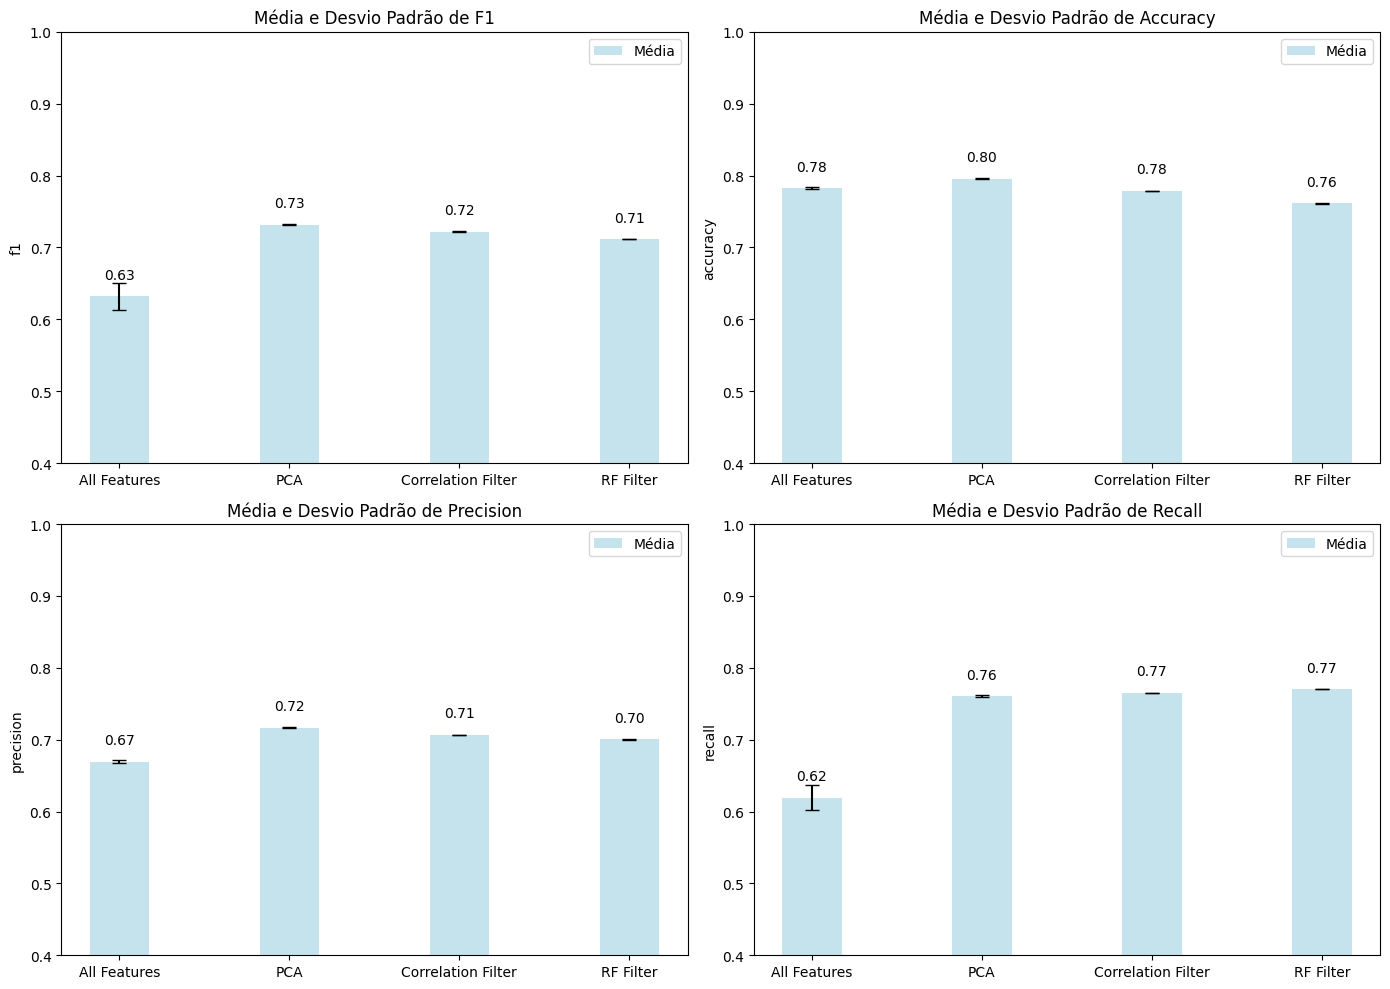

In [52]:
# Dados para os quatro cenários
data_all_features = {
    "f1": [
        0.602367,
        0.600509,
        0.609090,
        0.645127,
        0.643908,
        0.644891,
        0.642749,
        0.643586,
        0.644421,
        0.642589,
    ],
    "accuracy": [
        0.783410,
        0.783499,
        0.785626,
        0.782435,
        0.782081,
        0.782878,
        0.781372,
        0.781726,
        0.782081,
        0.781195,
    ],
    "precision": [
        0.665967,
        0.666021,
        0.671992,
        0.671091,
        0.670269,
        0.671703,
        0.668929,
        0.669662,
        0.670393,
        0.668626,
    ],
    "recall": [
        0.590836,
        0.589305,
        0.596300,
        0.632371,
        0.631133,
        0.631933,
        0.630101,
        0.630906,
        0.631711,
        0.629987,
    ],
}

data_pca = {
    "f1": [
        0.732789,
        0.730902,
        0.731559,
        0.732407,
        0.732860,
        0.731385,
        0.731249,
        0.731013,
        0.731946,
        0.732835,
    ],
    "accuracy": [
        0.797501,
        0.794045,
        0.796172,
        0.797235,
        0.796881,
        0.795108,
        0.794842,
        0.794222,
        0.795374,
        0.796792,
    ],
    "precision": [
        0.718004,
        0.715667,
        0.716736,
        0.717659,
        0.717848,
        0.716296,
        0.716126,
        0.715792,
        0.716767,
        0.717803,
    ],
    "recall": [
        0.760136,
        0.761385,
        0.759428,
        0.759677,
        0.761327,
        0.760768,
        0.760886,
        0.761354,
        0.761660,
        0.761414,
    ],
}

data_correlation_filter = {
    "f1": [
        0.721234,
        0.721267,
        0.721544,
        0.721822,
        0.722348,
        0.721988,
        0.722073,
        0.721990,
        0.721711,
        0.722321,
    ],
    "accuracy": [
        0.778447,
        0.778004,
        0.778359,
        0.778713,
        0.779511,
        0.778890,
        0.778802,
        0.778713,
        0.778536,
        0.779422,
    ],
    "precision": [
        0.706269,
        0.706347,
        0.706582,
        0.706819,
        0.707258,
        0.706965,
        0.707057,
        0.706984,
        0.706728,
        0.707240,
    ],
    "recall": [
        0.764234,
        0.765105,
        0.765188,
        0.765271,
        0.765205,
        0.765385,
        0.765761,
        0.765704,
        0.765302,
        0.765292,
    ],
}

data_rf_filter = {
    "f1": [
        0.711686,
        0.711076,
        0.710872,
        0.711643,
        0.712703,
        0.711969,
        0.711686,
        0.711441,
        0.711643,
        0.712621,
    ],
    "accuracy": [
        0.761343,
        0.760457,
        0.760457,
        0.761521,
        0.762673,
        0.761875,
        0.761343,
        0.761078,
        0.761521,
        0.762584,
    ],
    "precision": [
        0.700327,
        0.699963,
        0.699700,
        0.700191,
        0.701012,
        0.700443,
        0.700327,
        0.700138,
        0.700191,
        0.700949,
    ],
    "recall": [
        0.770304,
        0.770313,
        0.769736,
        0.769840,
        0.770579,
        0.770068,
        0.770304,
        0.770134,
        0.769840,
        0.770522,
    ],
}


# Função para calcular média e desvio padrão
def calculate_mean_std(data):
    return {"mean": np.mean(data), "std": np.std(data)}


# Armazenar resultados
results = {
    "All Features": {
        metric: calculate_mean_std(data_all_features[metric])
        for metric in data_all_features
    },
    "PCA": {metric: calculate_mean_std(data_pca[metric]) for metric in data_pca},
    "Correlation Filter": {
        metric: calculate_mean_std(data_correlation_filter[metric])
        for metric in data_correlation_filter
    },
    "RF Filter": {
        metric: calculate_mean_std(data_rf_filter[metric]) for metric in data_rf_filter
    },
}

# Criar os gráficos
metrics = ["f1", "accuracy", "precision", "recall"]
x = np.arange(len(results))  # Localização dos grupos
width = 0.35  # Largura das barras

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    means = [results[scenario][metric]["mean"] for scenario in results]
    stds = [results[scenario][metric]["std"] for scenario in results]

    bars = axes[i].bar(
        x,
        means,
        width,
        yerr=stds,
        label="Média",
        color="lightblue",
        alpha=0.7,
        capsize=5,
        ecolor="black",
        align="center",
    )  # Adicionando as barras de erro

    # Adicionar rótulos das médias
    for bar in bars:
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.02,
            f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=10,
        )  # centralizando o rótulo na barra e ajustando a altura

    axes[i].set_ylabel(metric)
    axes[i].set_title(f"Média e Desvio Padrão de {metric.capitalize()}")
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(results.keys())
    axes[i].legend()
    axes[i].set_ylim([0.4, 1])  # Ajusta o limite do eixo y para iniciar em 0.4

plt.tight_layout()
plt.show();
